<a href="https://colab.research.google.com/github/ymuto0302/PJ2025/blob/main/GAN_basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 簡易なGAN実装

In [16]:
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# GPU/CPUの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cuda


## データローダーの設定
MNIST データセットを持ってくる。

In [17]:
# データセットの準備
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # -1 to 1の範囲に正規化
])

# MNISTデータセットのダウンロード
print("MNISTデータセットをダウンロード中...")
mnist_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform
)
dataloader = DataLoader(mnist_dataset, batch_size=64, shuffle=True)

MNISTデータセットをダウンロード中...


## Generator

In [18]:
# Generator（生成器）の定義
class Generator(nn.Module):
    """
    GAN の Generator（生成器）クラス
    ランダムノイズから28x28の画像を生成する全結合層ベースのネットワーク
    """
    def __init__(self, nz=100, ngf=256, nc=1):
        """
        Args:
            nz (int): 入力ノイズベクトルの次元数（デフォルト: 100）
                        - ランダムな潜在変数の次元
                        - 一般的に64～512の値を使用
            ngf (int): Generator のフィルタ数の基準値（デフォルト: 256）
                        - ネットワークの容量を決定する基本単位
                        - 大きいほど表現力が向上するが計算コストも増加
            nc (int): 出力画像のチャンネル数（デフォルト: 1）
                        - 1: グレースケール画像（MNIST等）
                        - 3: カラー画像（RGB）
        """
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # 入力: nz次元のノイズベクトル
            nn.Linear(nz, ngf),
            nn.BatchNorm1d(ngf), # バッチ正規化による学習の安定化
            nn.ReLU(True),

            nn.Linear(ngf, ngf * 2),
            nn.BatchNorm1d(ngf * 2),
            nn.ReLU(True),

            nn.Linear(ngf * 2, ngf * 4),
            nn.BatchNorm1d(ngf * 4),
            nn.ReLU(True),

            # 出力: 28x28の画像
            nn.Linear(ngf * 4, nc * 28 * 28),
            nn.Tanh()  # -1 to 1の範囲に出力
        )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1, nc, 28, 28)

## Discriminator

In [19]:
# Discriminator（判別器）の定義
class Discriminator(nn.Module):
    """
    GAN の Discriminator（判別器）クラス
    28x28の画像を入力として、本物か偽物かを判定する二値分類器
    """
    def __init__(self, nc=1, ndf=256):
        """
        Args:
            nc (int): 入力画像のチャンネル数（デフォルト: 1）
                        - 1: グレースケール画像（MNIST等）
                        - 3: カラー画像（RGB）
            ndf (int): Discriminator のフィルタ数の基準値（デフォルト: 256）
                        - ネットワークの容量を決定する基本単位
                        - 大きいほど判別能力が向上するが過学習のリスクも増加
        """
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # 入力: 28x28の画像
            nn.Linear(nc * 28 * 28, ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            nn.Linear(ndf * 4, ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            nn.Linear(ndf * 2, ndf),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            # 出力: 本物/偽物の確率
            nn.Linear(ndf, 1),
            nn.Sigmoid()
        )

    def forward(self, input):
        """
        Returns:
            torch.Tensor: 本物である確率
                            形状: (batch_size,) 例: (64,)
                            値の範囲: 0.0〜1.0
                            - 0.0に近い: 偽物と判定
                            - 1.0に近い: 本物と判定
                            - 0.5付近: 判定困難（理想的な学習終了状態）
        """
        flattened = input.view(-1, 28 * 28)
        return self.main(flattened)

## メイン実行部分

In [21]:
# モデルの初期化
print("モデルの初期化...")
netG = Generator().to(device)
netD = Discriminator().to(device)

# 最適化器の設定
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))

# 損失関数
criterion = nn.BCELoss()

# 学習過程を記録するためのリスト
G_losses = []
D_losses = []

# モデル訓練関数
def train_gan(num_epochs=20, save_interval=5):
    print("GANの訓練スタート...")

    for epoch in range(num_epochs):
        epoch_g_loss = 0
        epoch_d_loss = 0
        num_batches = 0

        for i, (real_images, _) in enumerate(dataloader):
            # 時間短縮のため、最初の100バッチのみ処理
            '''
            if i >= 100:
                break
            '''

            batch_size = real_images.size(0)
            real_images = real_images.to(device)

            # ラベルの作成
            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            # ---------------------
            # Discriminatorの学習
            # ---------------------
            netD.zero_grad()

            # 本物画像での学習
            output = netD(real_images)
            errD_real = criterion(output, real_labels)

            # 偽物画像での学習
            noise = torch.randn(batch_size, 100).to(device)
            fake_images = netG(noise)
            output = netD(fake_images.detach())
            errD_fake = criterion(output, fake_labels)

            # Discriminatorの全体の損失
            errD = errD_real + errD_fake
            errD.backward()
            optimizerD.step()

            # ---------------------
            # Generatorの学習
            # ---------------------
            netG.zero_grad()

            # Generatorが作った画像をDiscriminatorに判定させる
            output = netD(fake_images)
            errG = criterion(output, real_labels)  # 本物ラベルで学習
            errG.backward()
            optimizerG.step()

            epoch_g_loss += errG.item()
            epoch_d_loss += errD.item()
            num_batches += 1

        # エポックごとの平均損失
        avg_g_loss = epoch_g_loss / num_batches
        avg_d_loss = epoch_d_loss / num_batches
        G_losses.append(avg_g_loss)
        D_losses.append(avg_d_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}] '
              f'Loss_D: {avg_d_loss:.4f} '
              f'Loss_G: {avg_g_loss:.4f}')

        # 定期的に生成画像を表示
        if (epoch + 1) % save_interval == 0:
            show_generated_images(epoch + 1)


# 生成画像を表示する関数
def show_generated_images(epoch, num_images=16):
    netG.eval()
    with torch.no_grad():
        noise = torch.randn(num_images, 100).to(device)
        fake_images = netG(noise)

        # -1 to 1の範囲を 0 to 1に変換
        fake_images = (fake_images + 1) / 2

        # 画像を表示
        fig, axes = plt.subplots(4, 4, figsize=(6, 6))
        for i, ax in enumerate(axes.flat):
            img = fake_images[i].cpu().squeeze().numpy()
            ax.imshow(img, cmap='gray')
            ax.axis('off')
        plt.suptitle(f'Generated Images - Epoch {epoch}')
        plt.tight_layout()
        # plt.show()
        fig.savefig(f'generated_images_epoch_{epoch:04}.png')
        plt.close(fig) # 画面表示を防ぐためにfigureを閉じる

    netG.train()

# モデル訓練の実行
train_gan(num_epochs=50, save_interval=5)

モデルの初期化...
GANの訓練スタート...
Epoch [1/50] Loss_D: 1.0353 Loss_G: 1.5880
Epoch [2/50] Loss_D: 0.9660 Loss_G: 1.5872
Epoch [3/50] Loss_D: 1.0459 Loss_G: 1.3294
Epoch [4/50] Loss_D: 1.1115 Loss_G: 1.2010
Epoch [5/50] Loss_D: 1.1834 Loss_G: 1.0722
Epoch [6/50] Loss_D: 1.2283 Loss_G: 0.9936
Epoch [7/50] Loss_D: 1.2655 Loss_G: 0.9344
Epoch [8/50] Loss_D: 1.2810 Loss_G: 0.9112
Epoch [9/50] Loss_D: 1.2937 Loss_G: 0.8865
Epoch [10/50] Loss_D: 1.3059 Loss_G: 0.8648
Epoch [11/50] Loss_D: 1.3185 Loss_G: 0.8412
Epoch [12/50] Loss_D: 1.3260 Loss_G: 0.8250
Epoch [13/50] Loss_D: 1.3324 Loss_G: 0.8131
Epoch [14/50] Loss_D: 1.3367 Loss_G: 0.8056
Epoch [15/50] Loss_D: 1.3398 Loss_G: 0.7991
Epoch [16/50] Loss_D: 1.3420 Loss_G: 0.7949
Epoch [17/50] Loss_D: 1.3450 Loss_G: 0.7894
Epoch [18/50] Loss_D: 1.3481 Loss_G: 0.7841
Epoch [19/50] Loss_D: 1.3509 Loss_G: 0.7740
Epoch [20/50] Loss_D: 1.3535 Loss_G: 0.7731
Epoch [21/50] Loss_D: 1.3535 Loss_G: 0.7695
Epoch [22/50] Loss_D: 1.3586 Loss_G: 0.7621
Epoch [23/50] Lo

## 学習曲線

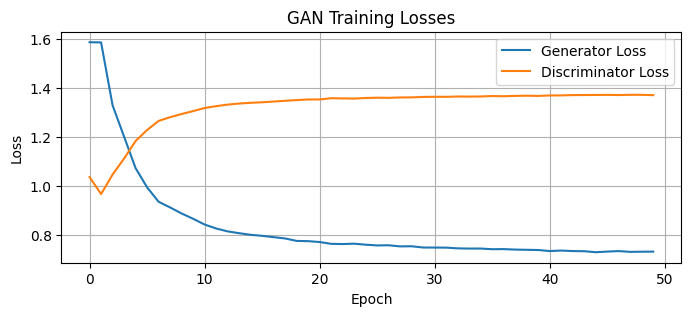

In [22]:
# 訓練データに対する損失の可視化
def plot_losses():
    plt.figure(figsize=(8, 3))
    plt.plot(G_losses, label='Generator Loss')
    plt.plot(D_losses, label='Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('GAN Training Losses')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_losses()

## 最終結果の表示

In [23]:
# 最終結果の表示
print("\n" + "=" * 50)
print("最終結果")
print("=" * 50)
show_generated_images("Final", num_images=16)
# (メモ)訓練過程での出力を抑えるため、表示しないこととした
# → generated_images_epoch_Final.png を参照のこと


最終結果


### 学習済みモデルの保存

In [24]:
# 学習済みモデルの保存
torch.save(netG.state_dict(), 'mnist_generator.pth')
torch.save(netD.state_dict(), 'mnist_discriminator.pth')

## (参考) seed を変えて画像生成

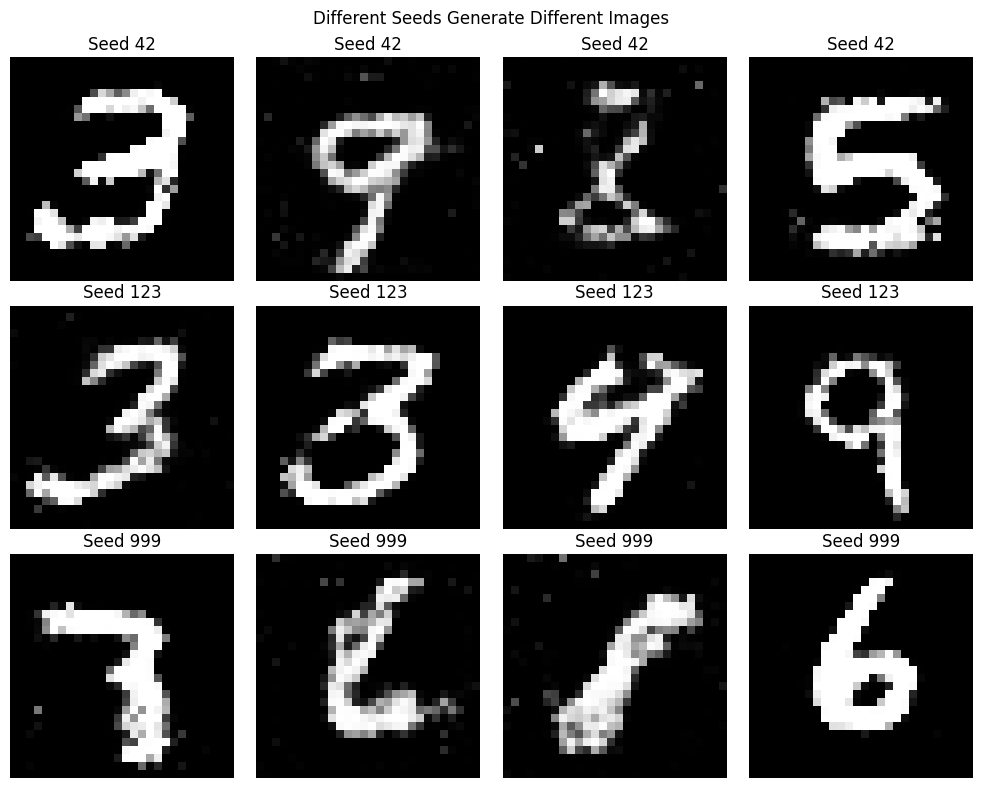

In [25]:
# 異なるノイズでの生成実験
def experiment_with_noise():
    netG.eval()

    # 3つの異なるランダムシードで実験
    seeds = [42, 123, 999]

    fig, axes = plt.subplots(3, 4, figsize=(10, 8))

    for i, seed in enumerate(seeds):
        torch.manual_seed(seed)
        noise = torch.randn(4, 100).to(device)

        with torch.no_grad():
            fake_images = netG(noise)
            fake_images = (fake_images + 1) / 2

        for j in range(4):
            img = fake_images[j].cpu().squeeze().numpy()
            axes[i, j].imshow(img, cmap='gray')
            axes[i, j].axis('off')
            axes[i, j].set_title(f'Seed {seed}')

    plt.suptitle('Different Seeds Generate Different Images')
    plt.tight_layout()
    plt.show()

    netG.train()

# 実験実行
experiment_with_noise()

In [11]:

%matplotlib inline